
# Monte Carlo Exploring Starts

需要保证所有的 state - action pair 都有概率被访问到，
最好是在初始化的时候遍历 state - action 

---

探索性搜索和贪心的更新策略被强制性的分成了第一次的遍历 

和之后的按策略选择


In [1]:
%matplotlib inline
import sys
from collections import defaultdict

if "../" not in sys.path:
    sys.path.append("../")
    
import numpy as np
from lib.envs.blackjack import BlackjackEnv
from lib.utils.draw import show_policy_black,show_value_function
import matplotlib

matplotlib.style.use('ggplot')
env = BlackjackEnv()

In [2]:
def get_policy(Q,nA):
    """
        
    """
    def policy_fn(observation):
        A = np.zeros(nA, dtype=float)
        best_action = np.argmax(Q[observation])
        A[best_action] = 1.0
        return A
    return policy_fn

In [3]:
def mc_exploring_starts(env,num_episodes,gamma=1.0):
    returns_num = defaultdict(float)
    returns_count = defaultdict(float)
    
    # 设置 map, value 的默认值为 [0,0]
    Q = defaultdict(lambda: np.zeros(env.nA))
    
    policy = get_policy(Q,env.nA)
    
    for i_episode in range(num_episodes):
        if i_episode % 10 == 0:
            # \r 实现动态更新
            print(f"\rEpisode :{i_episode/num_episodes * 100:.2f}%",end = "")
            sys.stdout.flush()
            
        # 遍历生成所有的情况
        for player in range(12,22): # player
            for dealer in range(1,11): # dealer
                for ace in (True, False):   # has ace ?
                    for ac in [0,1]:   # the first action

                        if ace:
                            player_list = [1,player-10 ]
                            dealer_list = [dealer]
                            state = env.set_reset(player_list,dealer_list)
                        else:
                            player_list= [player]
                            dealer_list = [dealer]
                            state = env.set_reset(player_list,dealer_list)
                        
                        first = True # 第一次用遍历的行为
                        stack_state_action = []
                        stack_reward = []   
                        
                        # 生成一个 episode
                        while True:
                            if first:                   # 第一个 action 用我们自己生成的
                                first = False
                                action = ac
                            else:
                                probs = policy(state)   # 之后的 action 用 policy 中的
                                action = np.random.choice( np.arange(len(probs)),p = probs )
                            # 
                            next_state, reward, done, _ = env.step(action)
                            stack_state_action.append( (state,action) )
                            stack_reward.append(reward)
                            if done:
                                break
                            state = next_state
                        # 回溯 episode
                        size = len(stack_reward)
                        G = 0
                        for i in range(size-1,-1,-1):
                            state, action = stack_state_action[i]
                            state = tuple(state)
                            key = (state, action)
                            
                            G = gamma * G + stack_reward[i]
                            if stack_state_action[i] not in stack_state_action[0:i]:
                                returns_num[key] += G
                                returns_count[key] += 1.0
                                Q[state][action] = returns_num[key] / returns_count[key]
    return Q,policy

In [4]:
Q, policy = mc_exploring_starts(env,num_episodes=10000,gamma=1.0)

Episode :99.90%

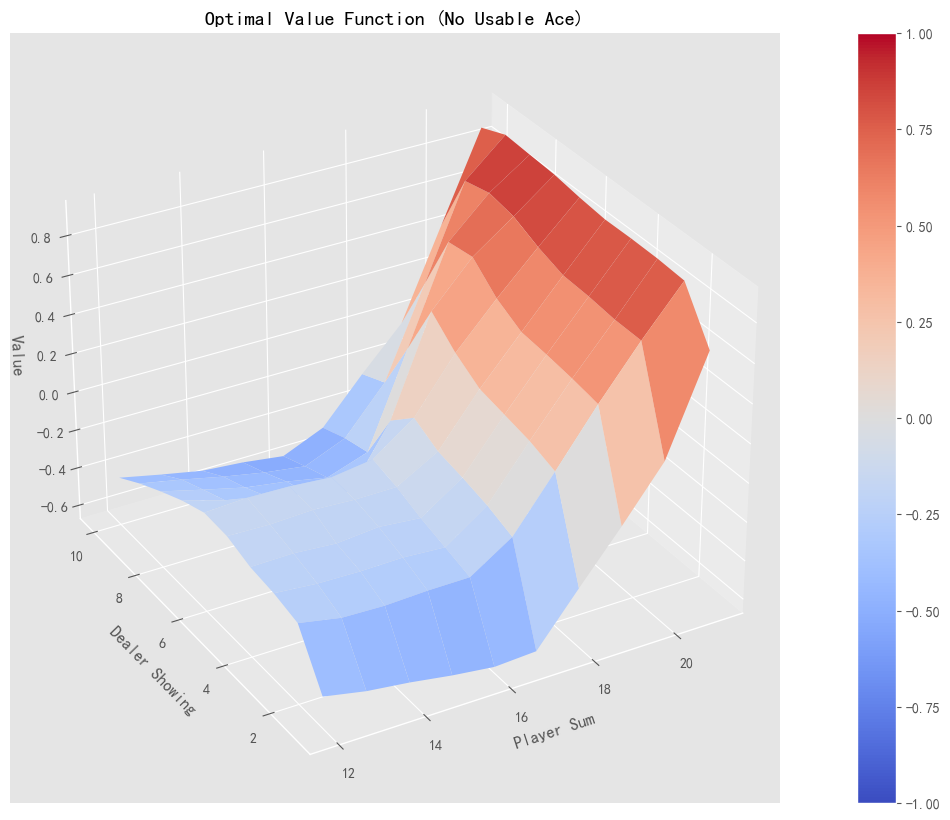

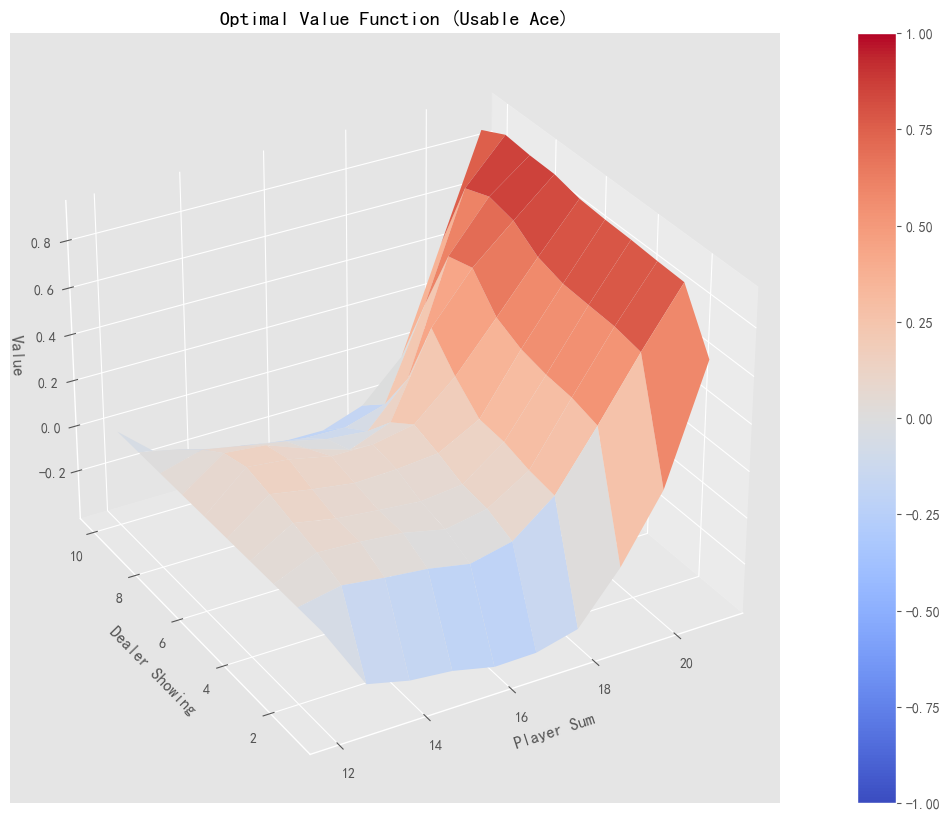

In [5]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
show_value_function(V, title="Optimal Value Function")

[[1. 1. 1. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


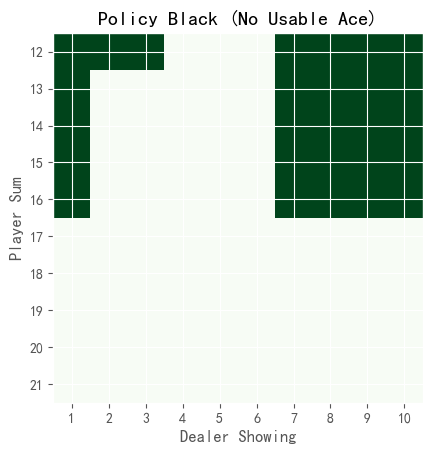

In [6]:

show_policy_black(policy,V,ace = False)

## the result in book
![img](../img/mc_exploring_starts.png)
## the result in code
![img](../img/3_traversal.png)
